# Introduction of features using stock price data

This notebook describes an example of training and building a model with feature generation using the excellent TA library.

From [Github](https://github.com/bukosabino/ta)
"It is a Technical Analysis library useful to do feature engineering from financial time series datasets (Open, Close, High, Low, Volume). It is built on Pandas and Numpy."

The library has implemented 42 indicators:

#### Volume

* Money Flow Index (MFI)
* Accumulation/Distribution Index (ADI)
* On-Balance Volume (OBV)
* Chaikin Money Flow (CMF)
* Force Index (FI)
* Ease of Movement (EoM, EMV)
* Volume-price Trend (VPT)
* Negative Volume Index (NVI)
* Volume Weighted Average Price (VWAP)

#### Volatility

* Average True Range (ATR)
* Bollinger Bands (BB)
* Keltner Channel (KC)
* Donchian Channel (DC)
* Ulcer Index (UI)

#### Trend

* Simple Moving Average (SMA)
* Exponential Moving Average (EMA)
* Weighted Moving Average (WMA)
* Moving Average Convergence Divergence (MACD)
* Average Directional Movement Index (ADX)
* Vortex Indicator (VI)
* Trix (TRIX)
* Mass Index (MI)
* Commodity Channel Index (CCI)
* Detrended Price Oscillator (DPO)
* KST Oscillator (KST)
* Ichimoku Kinkō Hyō (Ichimoku)
* Parabolic Stop And Reverse (Parabolic SAR)
* Schaff Trend Cycle (STC)

#### Momentum

* Relative Strength Index (RSI)
* Stochastic RSI (SRSI)
* True strength index (TSI)
* Ultimate Oscillator (UO)
* Stochastic Oscillator (SR)
* Williams %R (WR)
* Awesome Oscillator (AO)
* Kaufman's Adaptive Moving Average (KAMA)
* Rate of Change (ROC)
* Percentage Price Oscillator (PPO)
* Percentage Volume Oscillator (PVO)

#### Others

* Daily Return (DR)
* Daily Log Return (DLR)
* Cumulative Return (CR)


In [1]:
!pip install --upgrade ta

  Preparing metadata (setup.py) ... - done
  Created wheel for ta: filename=ta-0.9.0-py3-none-any.whl size=28907 sha256=662fad93d9d6c35407cf8179c7eec9b5d194df904f7820d3277371448e6dccb8
  Stored in directory: /root/.cache/pip/wheels/72/78/64/cc1c01506a1010a9845e9bd7c69333730f7174661228ea4f98
Successfully built ta


In [2]:
import os
from decimal import ROUND_HALF_UP, Decimal

import numpy as np
import pandas as pd
from lightgbm import LGBMRegressor
from tqdm import tqdm

import ta
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.style.use('seaborn')

In [3]:
# set base_dir to load data
base_dir = "../input/jpx-tokyo-stock-exchange-prediction"
# There are three types of stock_price.csv
# We use one in the train_files folder for this notebook.
train_files_dir = f"{base_dir}/train_files"

In [4]:
def adjust_price(price):
    """
    Args:
        price (pd.DataFrame)  : pd.DataFrame include stock_price
    Returns:
        price DataFrame (pd.DataFrame): stock_price with generated AdjustedClose
    """
    # transform Date column into datetime
    price.loc[: ,"Date"] = pd.to_datetime(price.loc[: ,"Date"], format="%Y-%m-%d")

    def generate_adjusted_close(df):
        """
        Args:
            df (pd.DataFrame)  : stock_price for a single SecuritiesCode
        Returns:
            df (pd.DataFrame): stock_price with AdjustedClose for a single SecuritiesCode
        """
        # sort data to generate CumulativeAdjustmentFactor
        df = df.sort_values("Date", ascending=False)
        # generate CumulativeAdjustmentFactor
        df.loc[:, "CumulativeAdjustmentFactor"] = df["AdjustmentFactor"].cumprod()
        # generate AdjustedClose
        df.loc[:, "AdjustedClose"] = (
            df["CumulativeAdjustmentFactor"] * df["Close"]
        ).map(lambda x: float(
            Decimal(str(x)).quantize(Decimal('0.1'), rounding=ROUND_HALF_UP)
        ))
        # reverse order
        df = df.sort_values("Date")
        # to fill AdjustedClose, replace 0 into np.nan
        df.loc[df["AdjustedClose"] == 0, "AdjustedClose"] = np.nan
        # forward fill AdjustedClose
        df.loc[:, "AdjustedClose"] = df.loc[:, "AdjustedClose"].ffill()
        return df

    # generate AdjustedClose
    price = price.sort_values(["SecuritiesCode", "Date"])
    price = price.groupby("SecuritiesCode").apply(generate_adjusted_close).reset_index(drop=True)

    price.set_index("Date", inplace=True)
    return price

In [5]:
# load stock price data
df_price = pd.read_csv(f"{train_files_dir}/stock_prices.csv")

# generate AdjustedClose
df_price = adjust_price(df_price)

In [6]:
df_price.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2332531 entries, 2017-01-04 to 2021-12-03
Data columns (total 13 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   RowId                       object 
 1   SecuritiesCode              int64  
 2   Open                        float64
 3   High                        float64
 4   Low                         float64
 5   Close                       float64
 6   Volume                      int64  
 7   AdjustmentFactor            float64
 8   ExpectedDividend            float64
 9   SupervisionFlag             bool   
 10  Target                      float64
 11  CumulativeAdjustmentFactor  float64
 12  AdjustedClose               float64
dtypes: bool(1), float64(9), int64(2), object(1)
memory usage: 233.6+ MB


In [7]:
df_price.head(5)

,RowId,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target,CumulativeAdjustmentFactor,AdjustedClose
Date,,,,,,,,,,,,,
2017-01-04,20170104_1301,1301,2734.0,2755.0,2730.0,2742.0,31400,1.0,NaN,False,0.000730,1.0,2742.0
2017-01-05,20170105_1301,1301,2743.0,2747.0,2735.0,2738.0,17900,1.0,NaN,False,0.002920,1.0,2738.0
2017-01-06,20170106_1301,1301,2734.0,2744.0,2720.0,2740.0,19900,1.0,NaN,False,-0.001092,1.0,2740.0
2017-01-10,20170110_1301,1301,2745.0,2754.0,2735.0,2748.0,24200,1.0,NaN,False,-0.005100,1.0,2748.0
2017-01-11,20170111_1301,1301,2748.0,2752.0,2737.0,2745.0,9300,1.0,NaN,False,-0.003295,1.0,2745.0


In [8]:
from ta import add_all_ta_features
from ta.utils import dropna

# Example: Nintendo Co., Ltd (SecuritiesCode: 7974)

In [9]:
nintendo_data = df_price.loc[df_price["SecuritiesCode"] == 7974].copy()

In [10]:
nintendo_data = ta.add_all_ta_features(
    nintendo_data, "Open", "High", "Low", "Close", "Volume", fillna=False
)

/opt/conda/lib/python3.7/site-packages/ta/trend.py:769: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
/opt/conda/lib/python3.7/site-packages/ta/trend.py:774: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)


In [11]:
nintendo_data.shape

(1202, 99)

## Bollinger Bands

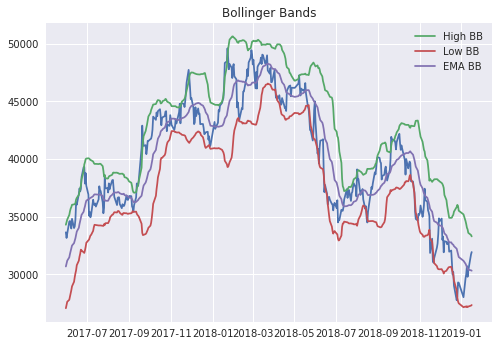

In [12]:
plt.plot(nintendo_data[100:500].Close)
plt.plot(nintendo_data[100:500].volatility_bbh, label='High BB')
plt.plot(nintendo_data[100:500].volatility_bbl, label='Low BB')
plt.plot(nintendo_data[100:500].volatility_bbm, label='EMA BB')
plt.title('Bollinger Bands')
plt.legend()
plt.show()

## MACD

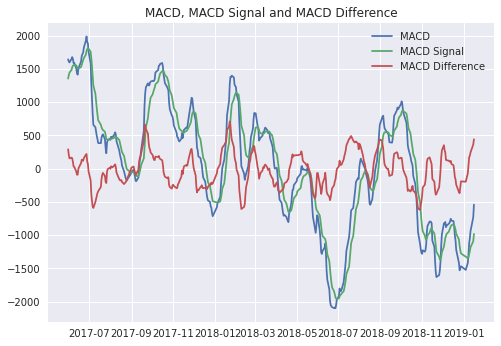

In [13]:
plt.plot(nintendo_data[100:500].trend_macd, label='MACD')
plt.plot(nintendo_data[100:500].trend_macd_signal, label='MACD Signal')
plt.plot(nintendo_data[100:500].trend_macd_diff, label='MACD Difference')
plt.title('MACD, MACD Signal and MACD Difference')
plt.legend()
plt.show()

## KST

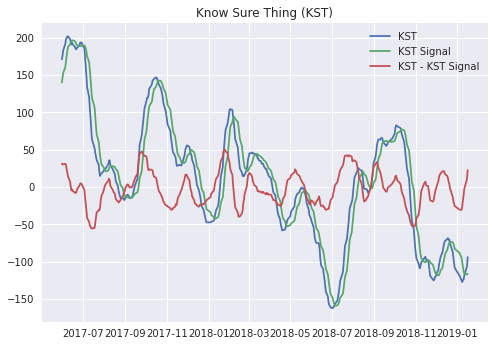

In [14]:
plt.plot(nintendo_data[100:500].trend_kst, label='KST')
plt.plot(nintendo_data[100:500].trend_kst_sig, label='KST Signal')
plt.plot(nintendo_data[100:500].trend_kst_diff, label='KST - KST Signal')
plt.title('Know Sure Thing (KST)')
plt.legend()
plt.show()

In [15]:
print(len(nintendo_data.columns))

99


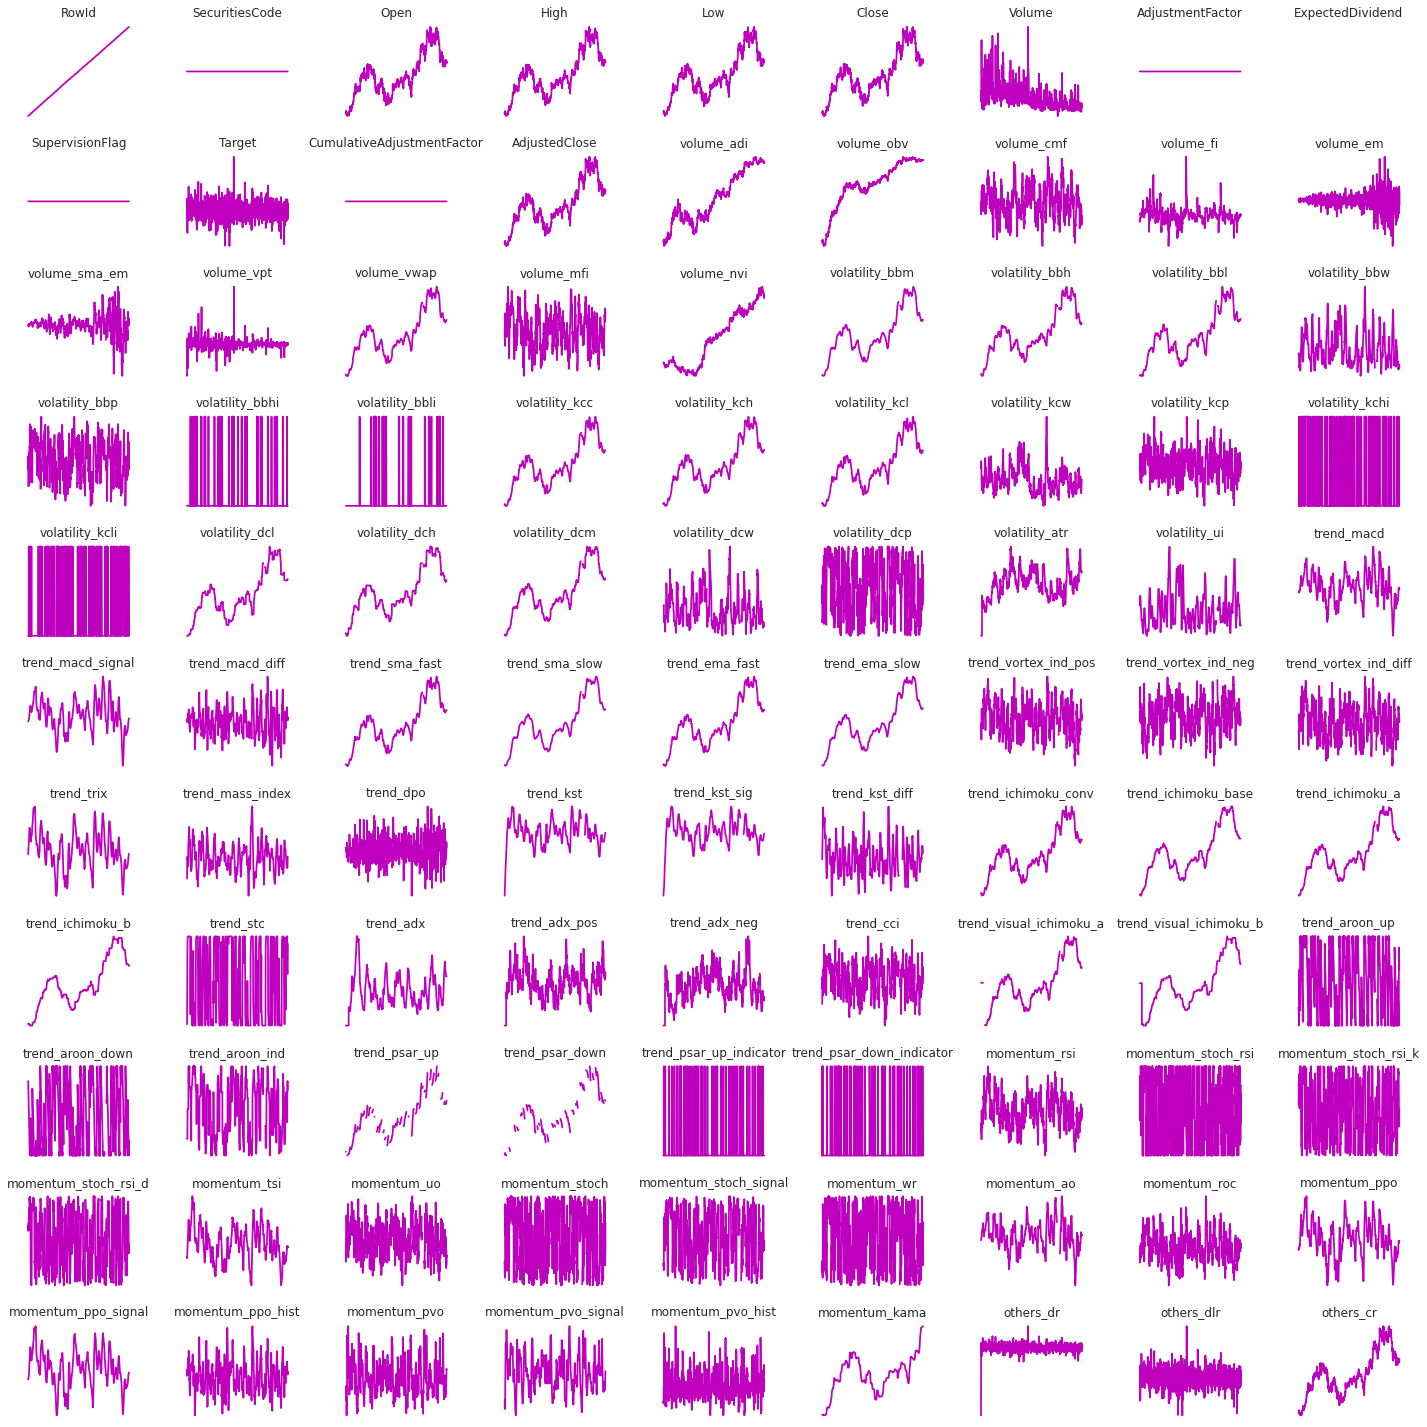

In [16]:
fig, ax = plt.subplots(11, 9, figsize=(20,20))
fig.tight_layout()
ax = ax.flatten()
for i, col in enumerate(nintendo_data.columns):
    ax[i].plot(nintendo_data[col], color="m")
    ax[i].title.set_text(col)
    ax[i].axis('off')
plt.show()

In [17]:
print(nintendo_data.columns)

Index(['RowId', 'SecuritiesCode', 'Open', 'High', 'Low', 'Close', 'Volume',
       'AdjustmentFactor', 'ExpectedDividend', 'SupervisionFlag', 'Target',
       'CumulativeAdjustmentFactor', 'AdjustedClose', 'volume_adi',
       'volume_obv', 'volume_cmf', 'volume_fi', 'volume_em', 'volume_sma_em',
       'volume_vpt', 'volume_vwap', 'volume_mfi', 'volume_nvi',
       'volatility_bbm', 'volatility_bbh', 'volatility_bbl', 'volatility_bbw',
       'volatility_bbp', 'volatility_bbhi', 'volatility_bbli',
       'volatility_kcc', 'volatility_kch', 'volatility_kcl', 'volatility_kcw',
       'volatility_kcp', 'volatility_kchi', 'volatility_kcli',
       'volatility_dcl', 'volatility_dch', 'volatility_dcm', 'volatility_dcw',
       'volatility_dcp', 'volatility_atr', 'volatility_ui', 'trend_macd',
       'trend_macd_signal', 'trend_macd_diff', 'trend_sma_fast',
       'trend_sma_slow', 'trend_ema_fast', 'trend_ema_slow',
       'trend_vortex_ind_pos', 'trend_vortex_ind_neg', 'trend_vortex_ind_di

# Example: Toyota Motor Corporation (SecuritiesCode: 7203)

In [18]:
toyota_data = df_price.loc[df_price["SecuritiesCode"] == 7203].copy()

In [19]:
toyota_data = ta.add_all_ta_features(
    toyota_data, "Open", "High", "Low", "Close", "Volume", fillna=False
)

/opt/conda/lib/python3.7/site-packages/ta/trend.py:769: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
/opt/conda/lib/python3.7/site-packages/ta/trend.py:774: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)


In [20]:
toyota_data.shape

(1202, 99)

## Bollinger Bands

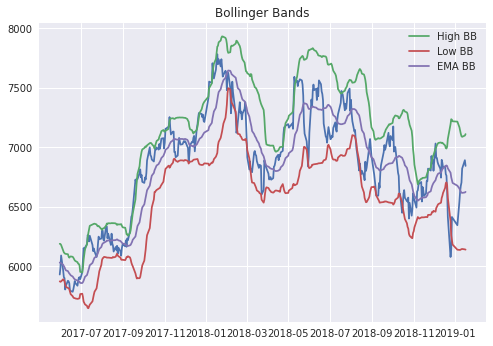

In [21]:
plt.plot(toyota_data[100:500].Close)
plt.plot(toyota_data[100:500].volatility_bbh, label='High BB')
plt.plot(toyota_data[100:500].volatility_bbl, label='Low BB')
plt.plot(toyota_data[100:500].volatility_bbm, label='EMA BB')
plt.title('Bollinger Bands')
plt.legend()
plt.show()

## MACD

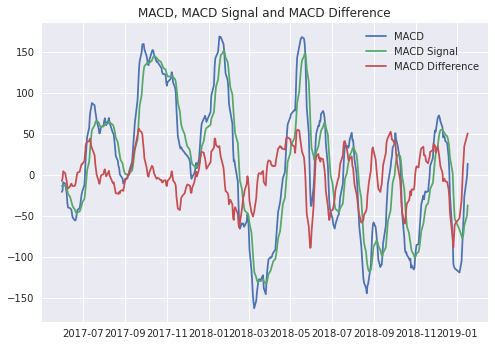

In [22]:
plt.plot(toyota_data[100:500].trend_macd, label='MACD')
plt.plot(toyota_data[100:500].trend_macd_signal, label='MACD Signal')
plt.plot(toyota_data[100:500].trend_macd_diff, label='MACD Difference')
plt.title('MACD, MACD Signal and MACD Difference')
plt.legend()
plt.show()

## KST

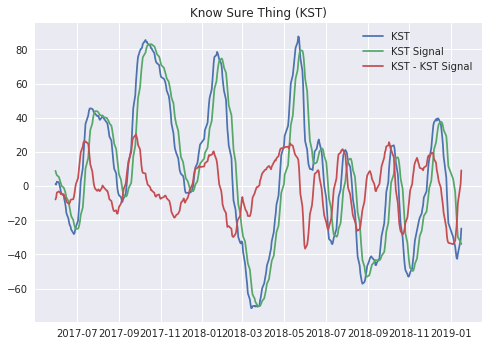

In [23]:
plt.plot(toyota_data[100:500].trend_kst, label='KST')
plt.plot(toyota_data[100:500].trend_kst_sig, label='KST Signal')
plt.plot(toyota_data[100:500].trend_kst_diff, label='KST - KST Signal')
plt.title('Know Sure Thing (KST)')
plt.legend()
plt.show()

In [24]:
print(len(toyota_data.columns))

99


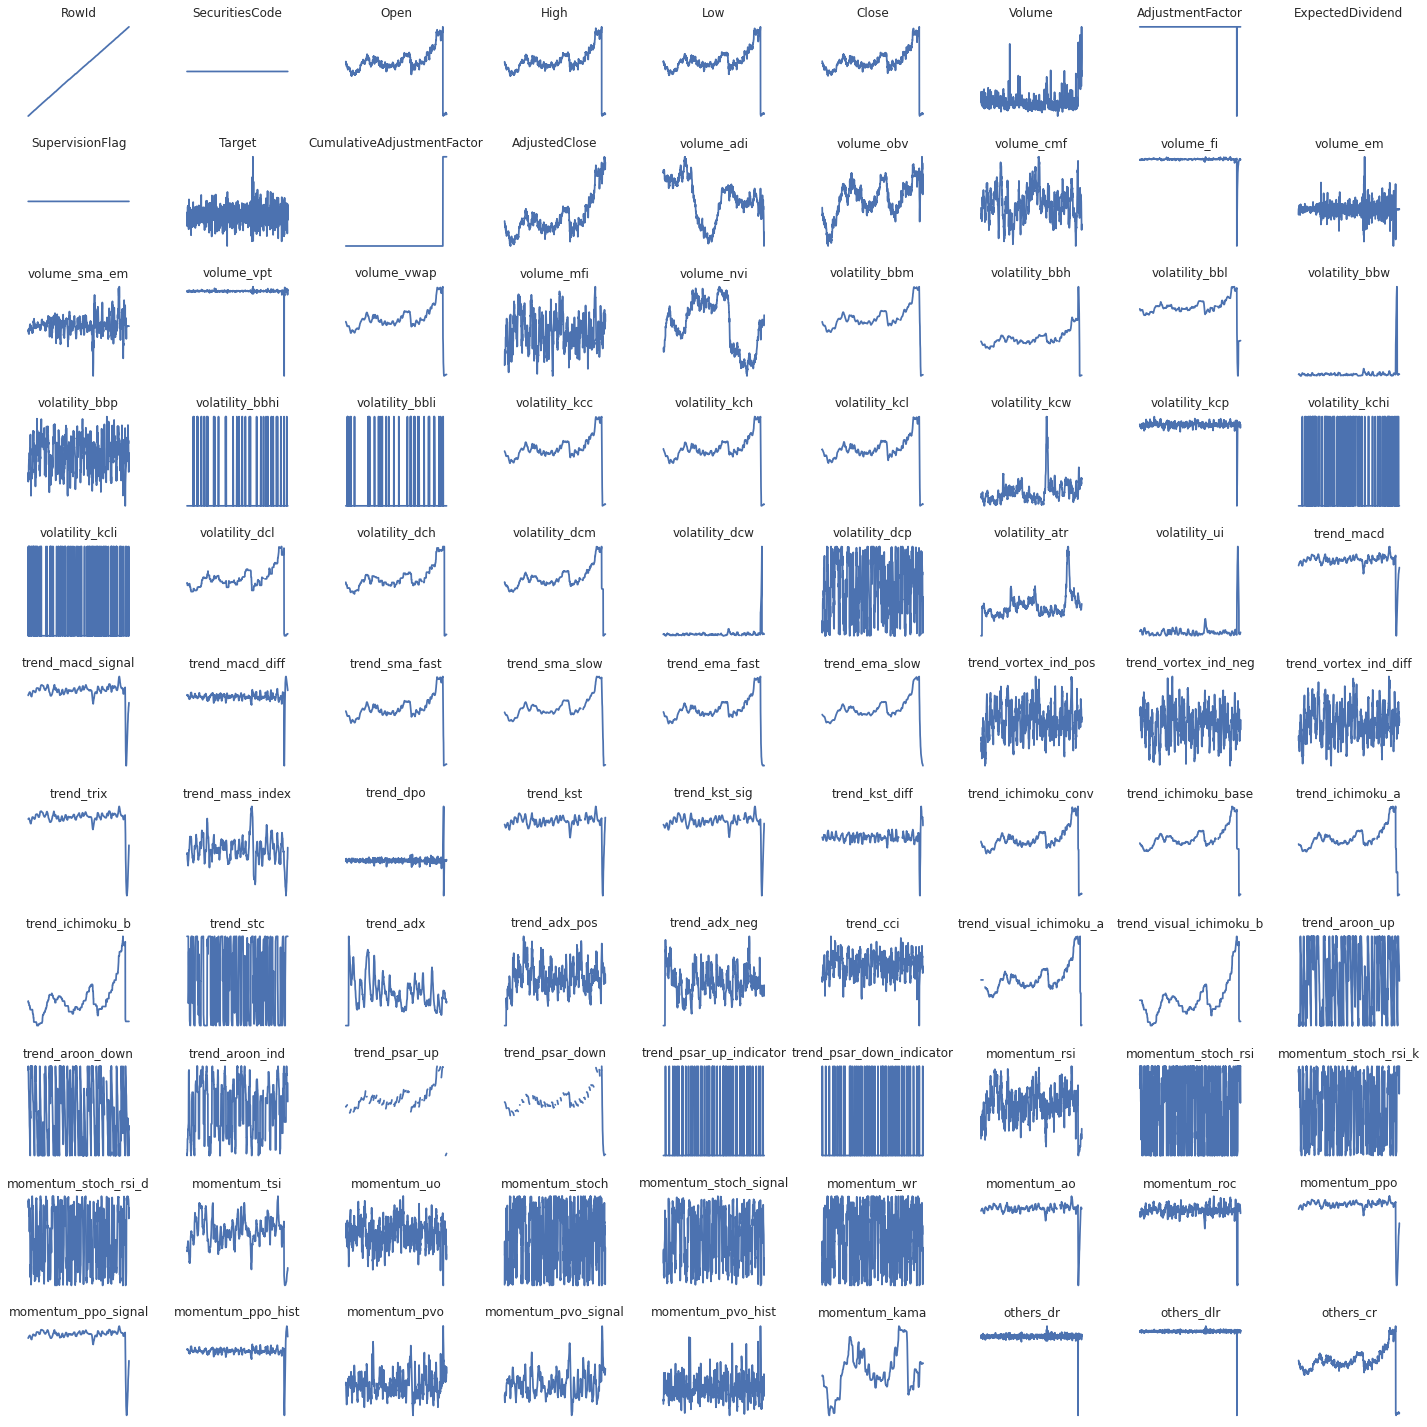

In [25]:
fig, ax = plt.subplots(11, 9, figsize=(20,20))
fig.tight_layout()
ax = ax.flatten()
for i, col in enumerate(toyota_data.columns):
    ax[i].plot(toyota_data[col])
    ax[i].title.set_text(col)
    ax[i].axis('off')
plt.show()

In [26]:
print(toyota_data.columns)

Index(['RowId', 'SecuritiesCode', 'Open', 'High', 'Low', 'Close', 'Volume',
       'AdjustmentFactor', 'ExpectedDividend', 'SupervisionFlag', 'Target',
       'CumulativeAdjustmentFactor', 'AdjustedClose', 'volume_adi',
       'volume_obv', 'volume_cmf', 'volume_fi', 'volume_em', 'volume_sma_em',
       'volume_vpt', 'volume_vwap', 'volume_mfi', 'volume_nvi',
       'volatility_bbm', 'volatility_bbh', 'volatility_bbl', 'volatility_bbw',
       'volatility_bbp', 'volatility_bbhi', 'volatility_bbli',
       'volatility_kcc', 'volatility_kch', 'volatility_kcl', 'volatility_kcw',
       'volatility_kcp', 'volatility_kchi', 'volatility_kcli',
       'volatility_dcl', 'volatility_dch', 'volatility_dcm', 'volatility_dcw',
       'volatility_dcp', 'volatility_atr', 'volatility_ui', 'trend_macd',
       'trend_macd_signal', 'trend_macd_diff', 'trend_sma_fast',
       'trend_sma_slow', 'trend_ema_fast', 'trend_ema_slow',
       'trend_vortex_ind_pos', 'trend_vortex_ind_neg', 'trend_vortex_ind_di

# Pre-processing for model building

This notebook presents a simple model using LightGBM.

First, the features are generated using the price change and historical volatility described above.

In [27]:
def get_features_for_predict(price, code):
    """
    Args:
        price (pd.DataFrame)  : pd.DataFrame include stock_price
        code (int)  : A local code for a listed company
    Returns:
        feature DataFrame (pd.DataFrame)
    """
    close_col = "AdjustedClose"
    feats = price.loc[price["SecuritiesCode"] == code].copy()
    
    # Adds all 42 features
    feats = ta.add_all_ta_features(
        feats, "Open", "High", "Low", close_col, "Volume", fillna=False
    )
    
    # To only add specific features
    # Example: https://github.com/bukosabino/ta/blob/master/examples_to_use/bollinger_band_features_example.py
    # df['bb_bbm'] = indicator_bb.bollinger_mavg()
    # df['bb_bbh'] = indicator_bb.bollinger_hband()
    # df['bb_bbl'] = indicator_bb.bollinger_lband()
    
    # filling data for nan and inf
    feats = feats.fillna(0)
    feats = feats.replace([np.inf, -np.inf], 0)
    # drop AdjustedClose column
    feats = feats.drop([close_col], axis=1)

    return feats

In [28]:
# fetch prediction target SecuritiesCodes
codes = sorted(df_price["SecuritiesCode"].unique())
len(codes)

2000

In [29]:
# generate feature
buff = []
for code in tqdm(codes):
    feat = get_features_for_predict(df_price, code)
    buff.append(feat)
feature = pd.concat(buff)

  0%|          | 0/2000 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/ta/trend.py:769: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
/opt/conda/lib/python3.7/site-packages/ta/trend.py:774: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)
100%|██████████| 2000/2000 [18:39<00:00,  1.79it/s]


In [30]:
feature.tail(2)

,RowId,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,...,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,momentum_pvo,momentum_pvo_signal,momentum_pvo_hist,momentum_kama,others_dr,others_dlr,others_cr
Date,,,,,,,,,,,,,,,,,,,,,
2021-12-02,20211202_9997,9997,681.0,692.0,680.0,684.0,342900,1.0,0.0,False,...,-4.346809,-3.963781,-0.383028,5.612814,0.840525,4.772289,685.744007,-0.145985,-0.146092,-12.082262
2021-12-03,20211203_9997,9997,690.0,711.0,686.0,696.0,381100,1.0,0.0,False,...,-4.098638,-3.990753,-0.107886,7.893174,2.251055,5.642119,686.173130,1.754386,1.739174,-10.539846


# Label creation

Next, we obtain the labels to be used for training the model (this is where we load and split the label data).

In [31]:
def get_label(price, code):
    """ Labelizer
    Args:
        price (pd.DataFrame): dataframe of stock_price.csv
        code (int): Local Code in the universe
    Returns:
        df (pd.DataFrame): label data
    """
    df = price.loc[price["SecuritiesCode"] == code].copy()
    df.loc[:, "label"] = df["Target"]

    return df.loc[:, ["SecuritiesCode", "label"]]

In [32]:
# split data into TRAIN and TEST
TRAIN_END = "2019-12-31"
# We put a week gap between TRAIN_END and TEST_START
# to avoid leakage of test data information from label
TEST_START = "2020-01-06"

def get_features_and_label(price, codes, features):
    """
    Args:
        price (pd.DataFrame): loaded price data
        codes  (array) : target codes
        feature (pd.DataFrame): features
    Returns:
        train_X (pd.DataFrame): training data
        train_y (pd.DataFrame): label for train_X
        test_X (pd.DataFrame): test data
        test_y (pd.DataFrame): label for test_X
    """
    # to store splited data
    trains_X, tests_X = [], []
    trains_y, tests_y = [], []

    # generate feature one by one
    for code in tqdm(codes):

        feats = features[features["SecuritiesCode"] == code].dropna()
        labels = get_label(price, code).dropna()

        if feats.shape[0] > 0 and labels.shape[0] > 0:
            # align label and feature indexes
            labels = labels.loc[labels.index.isin(feats.index)]
            feats = feats.loc[feats.index.isin(labels.index)]

            assert (labels.loc[:, "SecuritiesCode"] == feats.loc[:, "SecuritiesCode"]).all()
            labels = labels.loc[:, "label"]

            # split data into TRAIN and TEST
            _train_X = feats[: TRAIN_END]
            _test_X = feats[TEST_START:]

            _train_y = labels[: TRAIN_END]
            _test_y = labels[TEST_START:]
            
            assert len(_train_X) == len(_train_y)
            assert len(_test_X) == len(_test_y)

            # store features
            trains_X.append(_train_X)
            tests_X.append(_test_X)
            # store labels
            trains_y.append(_train_y)
            tests_y.append(_test_y)
            
    # combine features for each codes
    train_X = pd.concat(trains_X)
    test_X = pd.concat(tests_X)
    # combine label for each codes
    train_y = pd.concat(trains_y)
    test_y = pd.concat(tests_y)

    return train_X, train_y, test_X, test_y

In [33]:
# generate feature/label
train_X, train_y, test_X, test_y = get_features_and_label(
    df_price, codes, feature
)

100%|██████████| 2000/2000 [00:45<00:00, 43.51it/s]


# Building a simple model

Using the a selected subset of features and labels, build a model using the following procedure

In [34]:
lgbm_params = {
    'seed': 42,
    'n_jobs': -1,
}

feat_cols = [
    "momentum_rsi",
    "trend_macd",
    "trend_kst",
    "trend_ema_fast",
    "volatility_bbm",
    "volatility_atr",
]

In [35]:
# initialize model
pred_model = LGBMRegressor(**lgbm_params)
# train
pred_model.fit(train_X[feat_cols].values, train_y)
# prepare result data
result = test_X[["SecuritiesCode"]].copy()
# predict
result.loc[:, "predict"] = pred_model.predict(test_X[feat_cols])
# actual result
result.loc[:, "Target"] = test_y.values

def set_rank(df):
    """
    Args:
        df (pd.DataFrame): including predict column
    Returns:
        df (pd.DataFrame): df with Rank
    """
    # sort records to set Rank
    df = df.sort_values("predict", ascending=False)
    # set Rank starting from 0
    df.loc[:, "Rank"] = np.arange(len(df["predict"]))
    return df

result = result.sort_values(["Date", "predict"], ascending=[True, False])
result = result.groupby("Date").apply(set_rank)

In [36]:
result.tail()

,SecuritiesCode,predict,Target,Rank
Date,,,,
2021-12-03,4169,-0.004384,-0.036508,1995
2021-12-03,6881,-0.004738,0.038156,1996
2021-12-03,6378,-0.004793,0.009677,1997
2021-12-03,7030,-0.005376,0.025575,1998
2021-12-03,6879,-0.005893,-0.020588,1999


# Evaluation

Input the output of the forecasts of the constructed model into the evaluation function and plot the daily returns.

The evaluation function for this competition is as follows.

Please read [here](https://www.kaggle.com/code/smeitoma/jpx-competition-metric-definition) to know the evaluation function more.

In [37]:
def calc_spread_return_sharpe(df: pd.DataFrame, portfolio_size: int = 200, toprank_weight_ratio: float = 2) -> float:
    """
    Args:
        df (pd.DataFrame): predicted results
        portfolio_size (int): # of equities to buy/sell
        toprank_weight_ratio (float): the relative weight of the most highly ranked stock compared to the least.
    Returns:
        (float): sharpe ratio
    """
    def _calc_spread_return_per_day(df, portfolio_size, toprank_weight_ratio):
        """
        Args:
            df (pd.DataFrame): predicted results
            portfolio_size (int): # of equities to buy/sell
            toprank_weight_ratio (float): the relative weight of the most highly ranked stock compared to the least.
        Returns:
            (float): spread return
        """
        assert df['Rank'].min() == 0
        assert df['Rank'].max() == len(df['Rank']) - 1
        weights = np.linspace(start=toprank_weight_ratio, stop=1, num=portfolio_size)
        purchase = (df.sort_values(by='Rank')['Target'][:portfolio_size] * weights).sum() / weights.mean()
        short = (df.sort_values(by='Rank', ascending=False)['Target'][:portfolio_size] * weights).sum() / weights.mean()
        return purchase - short

    buf = df.groupby('Date').apply(_calc_spread_return_per_day, portfolio_size, toprank_weight_ratio)
    sharpe_ratio = buf.mean() / buf.std()
    return sharpe_ratio

In [38]:
# calc spread return sharpe
calc_spread_return_sharpe(result, portfolio_size=200)

0.10406011593299501

Then, we will show daily spread return of the model.

In [39]:
def _calc_spread_return_per_day(df, portfolio_size, toprank_weight_ratio):
    """
    Args:
        df (pd.DataFrame): predicted results
        portfolio_size (int): # of equities to buy/sell
        toprank_weight_ratio (float): the relative weight of the most highly ranked stock compared to the least.
    Returns:
        (float): spread return
    """
    assert df['Rank'].min() == 0
    assert df['Rank'].max() == len(df['Rank']) - 1
    weights = np.linspace(start=toprank_weight_ratio, stop=1, num=portfolio_size)
    purchase = (df.sort_values(by='Rank')['Target'][:portfolio_size] * weights).sum() / weights.mean()
    short = (df.sort_values(by='Rank', ascending=False)['Target'][:portfolio_size] * weights).sum() / weights.mean()
    return purchase - short

df_result = result.groupby('Date').apply(_calc_spread_return_per_day, 200, 2)

<AxesSubplot:xlabel='Date'>

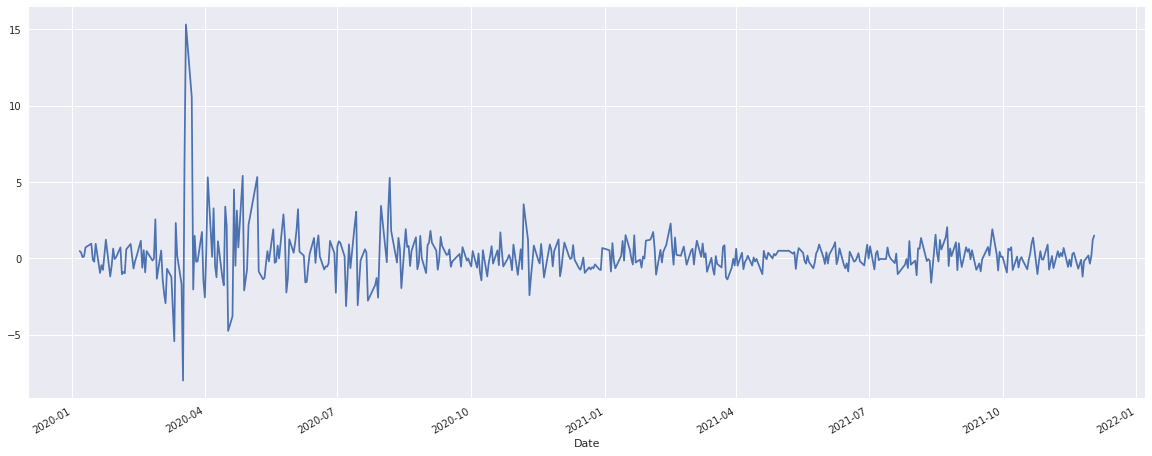

In [40]:
df_result.plot(figsize=(20, 8))

We also show a cumulative spread return of the mode

<AxesSubplot:xlabel='Date'>

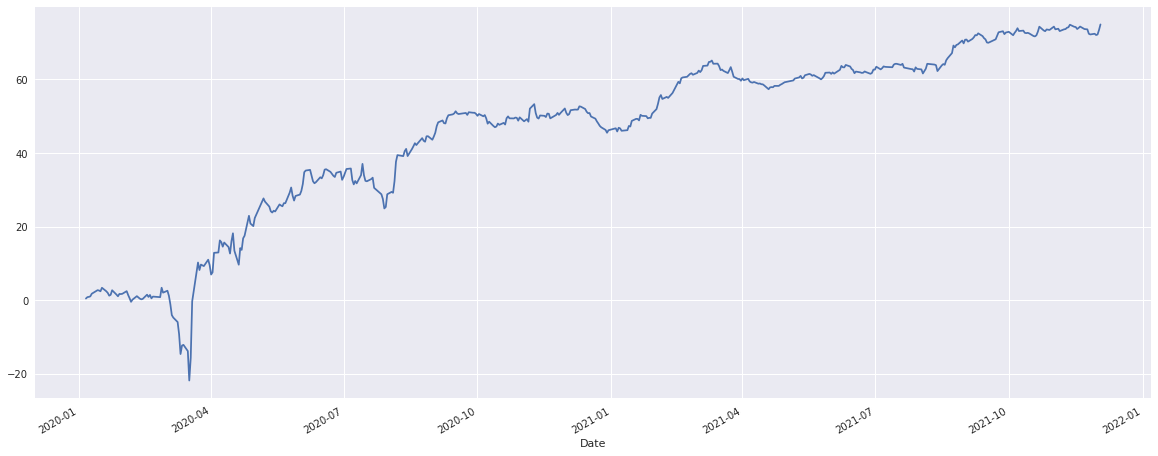

In [41]:
df_result.cumsum().plot(figsize=(20, 8))

The model in this notebook is now complete! Try different features and training methods through trial and error!

# Saving model

You need to save your model parameter to use created model for your submission.

In [42]:
pred_model.booster_.save_model("simple-model.txt")

### Please don't forget to link if you found this notebook useful 🙏 🥰